# Graph Neural Network Feature Importance Analysis

This notebook implements a GNN-based approach to analyze feature importance for graph property prediction using two methods:
1. Perturbation Analysis - Measures impact of perturbing individual features
2. Hybrid Analysis - Combines perturbation results with focused feature subset testing

## Imports
<!-- This program uses a Graph Neural Network (GNN) to analyze and predict graph properties. It specifically focuses on understanding the relationships between different network metrics and how they influence each other. 

This is accomplished using a technique called Normalized Perturbation Analysis which we use to measure feature importance by systematically modifying input features and observing the impact on the model's predictions. You can specify any single graph property and the program will analyze all other features, ranking them in how important they are to predicting the specified feature. -->

In [233]:
# Version 1.0
!pip install tabulate itertools

# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from scipy.stats import spearmanr
import networkx as nx
import numpy as np
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data
from tabulate import tabulate
import matplotlib.pyplot as plt

ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools


## Feature Definitions
Define all graph features used in the analysis, including node-level and global properties.

In [234]:
# Model Architecture
MODEL_CONFIG = {
    'hidden_dim': 32,
    'num_layers': 2,
    'dropout_rate': 0.2,
    'batch_norm': True,
    'layer_norm': False,      # Remove one normalization layer
    'residual': True
}

TRAINING_CONFIG = {
    'num_epochs': 100,
    'learning_rate': 0.0005,
    'weight_decay': 1e-4,
    'early_stopping': {
        'enabled': False,
        'patience': 15,
        'min_delta': 1e-4
    },
    'optimizer': {
        'type': 'AdamW',
        'beta1': 0.9,
        'beta2': 0.999,
        'eps': 1e-8
    },
    'train_val_split': 0.8
}

# Analysis Configuration
ANALYSIS_CONFIG = {
    'perturbation': {
        'num_trials': 10,
        'scales': [0.1, 0.5, 1.0],
        'feature_subset': None  # Analyze all features
    },
    'hybrid': {
        'num_trials': 5,
        'mask_ratio': 0.5    # Ratio of feature values to mask
    }
}

# Node-level metrics for the n-node subgraph removed from G
NODE_METRICS = [
    'Degree', 
    'Clustering', 
    'NeighborDeg', 
    'Betweenness',
    'Closeness', 
    'PageRank', 
    'CoreNumber', 
    'LocalEff', 
    'Eigenvector'
]

# Global metrics for the entire graph G
GLOBAL_METRICS = [
    'GraphDensity',
    'AvgClustering',
    'AvgPathLength',
    'DegreeAssortativity',
    'Transitivity',
    'ConnectedComponents',
    'MaxDegree',
    'MinDegree',
    'AvgDegree',
    'GlobalEfficiency'
]

# Generate feature names programmatically
FEATURE_NAMES = [
    f"Node{i+1}_{metric}" 
    for i in range(4) 
    for metric in NODE_METRICS
] + GLOBAL_METRICS

## Model Architecture
GNN implementation supporting both perturbation and hybrid analysis

In [235]:
class SingleFeatureGNNModel(nn.Module):
    def __init__(self, node_feature_dim):
        super().__init__()
        hidden_dim = MODEL_CONFIG['hidden_dim']  # Get hidden_dim from config
        self.dropout = nn.Dropout(MODEL_CONFIG['dropout_rate'])
        
        # First GCN layer
        self.conv1 = GCNConv(node_feature_dim, hidden_dim)
        if MODEL_CONFIG['batch_norm']:
            self.bn1 = nn.BatchNorm1d(hidden_dim)
        if MODEL_CONFIG['layer_norm']:
            self.ln1 = nn.LayerNorm(hidden_dim)
        
        # Second GCN layer
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        if MODEL_CONFIG['batch_norm']:
            self.bn2 = nn.BatchNorm1d(hidden_dim)
        if MODEL_CONFIG['layer_norm']:
            self.ln2 = nn.LayerNorm(hidden_dim)
        
        self.final_layer = nn.Linear(hidden_dim, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # First layer
        x1 = self.conv1(x, edge_index)
        if hasattr(self, 'bn1'):
            x1 = self.bn1(x1)
        if hasattr(self, 'ln1'):
            x1 = self.ln1(x1)
        x1 = F.relu(x1)
        x1 = self.dropout(x1)
        
        # Second layer with residual connection
        x2 = self.conv2(x1, edge_index)
        if hasattr(self, 'bn2'):
            x2 = self.bn2(x2)
        if hasattr(self, 'ln2'):
            x2 = self.ln2(x2)
        x2 = F.relu(x2)
        if MODEL_CONFIG['residual']:
            x2 = self.dropout(x2 + x1)
        else:
            x2 = self.dropout(x2)
        
        return self.final_layer(x2)

## Data Processing and Graph Generation
Functions for creating random graphs and computing their properties.

In [236]:
def generate_graph(num_nodes=100, edge_prob=0.05):
    """Generate a random graph ensuring it has at least one connected component of size 4"""
    while True:
        G = nx.erdos_renyi_graph(n=num_nodes, p=edge_prob)
        connected_nodes = find_connected_subgraph(G, size=4)
        if connected_nodes is not None:
            return G, connected_nodes

def find_connected_subgraph(G, size=4):
    """Find a connected subgraph of specified size"""
    for component in nx.connected_components(G):
        subgraph = G.subgraph(component)
        if len(subgraph) >= size:
            start_node = np.random.choice(list(subgraph.nodes()))
            nodes = list(nx.bfs_tree(subgraph, start_node))[:size]
            return nodes
    return None

def compute_local_efficiency(G, node):
    """
    Compute local efficiency for a node in the graph
    """
    neighbors = list(G.neighbors(node))
    if len(neighbors) < 2:
        return 0.0
    
    # Create subgraph of node's neighbors
    subgraph = G.subgraph(neighbors)
    if len(subgraph) < 2:
        return 0.0
    
    try:
        # Calculate average shortest path length in subgraph
        avg_path_length = nx.average_shortest_path_length(subgraph)
        return 1.0 / avg_path_length if avg_path_length > 0 else 0.0
    except nx.NetworkXError:
        # Handle disconnected graphs
        return 0.0

def compute_features(G, nodes):
    if nodes is None or len(nodes) != 4:
        raise ValueError("Must provide exactly 4 nodes for feature computation")
    
    features = []
    n_nodes = len(G)

    def normalize_metric_dict(metric_dict, min_val=0.1):
        """Normalize dictionary values to [min_val, 1] range."""
        values = np.array(list(metric_dict.values()))
        min_metric = np.min(values)
        max_metric = np.max(values)
        
        if max_metric == min_metric:
            return {k: min_val for k in metric_dict.keys()}
            
        normalized = {
            k: min_val + (v - min_metric) * (1 - min_val) / (max_metric - min_metric)
            for k, v in metric_dict.items()
        }
        return normalized
    
    # Pre-compute and normalize all centrality metrics
    try:
        # Compute and normalize basic centrality metrics
        betweenness = normalize_metric_dict(nx.betweenness_centrality(G))
        closeness = normalize_metric_dict(nx.closeness_centrality(G))
        pagerank = normalize_metric_dict(nx.pagerank(G))
        core_numbers = normalize_metric_dict(nx.core_number(G))
        degrees = normalize_metric_dict(dict(G.degree()))
        
        # Custering computation and normalization
        clustering = nx.clustering(G)
        clustering = normalize_metric_dict(clustering)
        
        # Handle eigenvector centrality for largest component
        largest_cc = max(nx.connected_components(G), key=len)
        subgraph = G.subgraph(largest_cc)
        eigenvector = nx.eigenvector_centrality_numpy(subgraph)
        min_eigen = min(eigenvector.values())
        eigenvector.update({n: min_eigen for n in G.nodes() if n not in eigenvector})
        eigenvector = normalize_metric_dict(eigenvector)
        
    except Exception as e:
        print(f"Error computing centrality metrics: {str(e)}")
        raise
    
    # Process each node
    for node in nodes:
        # Calculate neighbor-based metrics
        neighbors = list(G.neighbors(node))
        avg_neighbor_degree = (
            np.mean([degrees[n] for n in neighbors]) 
            if neighbors else 0.1  # Use minimum value if no neighbors
        )
        
        # Compile node features
        node_features = [
            degrees[node],
            clustering[node],
            avg_neighbor_degree,
            betweenness[node],
            closeness[node],
            pagerank[node],
            core_numbers[node],
            compute_local_efficiency(G, node),
            eigenvector[node]
        ]
        features.extend(node_features)
    
    # Compute and normalize global features
    global_features = [
        nx.density(G),
        nx.average_clustering(G),
        nx.average_shortest_path_length(G) / n_nodes if nx.is_connected(G) else 0.1,
        nx.degree_assortativity_coefficient(G),
        nx.transitivity(G),
        len(list(nx.connected_components(G))) / n_nodes,
        max(degrees.values()),
        min(degrees.values()),
        np.mean(list(degrees.values())),
        nx.global_efficiency(G)
    ]
    
    # Normalize global features
    global_features = normalize_metric_dict(
        {str(i): v for i, v in enumerate(global_features)}
    ).values()
    
    features.extend(global_features)
    return torch.tensor(features, dtype=torch.float32)

def process_graph_data(G, selected_nodes, target_idx):
    """Process graph data with proper node-wise feature variation"""
    # Compute features
    all_features = compute_features(G, selected_nodes)
    
    if not isinstance(all_features, torch.Tensor):
        all_features = torch.tensor(all_features, dtype=torch.float)
    
    num_nodes = len(G)
    num_features = len(FEATURE_NAMES) - 1
    x = torch.zeros((num_nodes, num_features))
    
    # Add node-wise variation to features
    current_idx = 0
    for i in range(len(FEATURE_NAMES)):
        if i != target_idx:
            base_value = all_features[i].clone()
            # Create node-specific variations
            variations = torch.randn(num_nodes) * 0.1  # 10% variation
            node_values = base_value + variations
            # Ensure values stay in reasonable range
            node_values = torch.clamp(node_values, min=0.0, max=1.0)
            x[:, current_idx] = node_values
            current_idx += 1
    
    # Prepare edge index
    edge_list = list(G.edges())
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    
    # Create data object
    data = Data(
        x=x,
        edge_index=edge_index,
        original_features=all_features
    )
    
    print("\nData Processing Debug:")
    print(f"Number of nodes: {num_nodes}")
    print(f"Number of features: {num_features}")
    print(f"Feature tensor shape: {x.shape}")
    print(f"Edge index shape: {edge_index.shape}")
    print(f"Sample feature means: {x.mean(dim=0)[:5]}")
    print(f"Sample feature stds: {x.std(dim=0)[:5]}")
    
    return data

## Feature Importance Analysis Methods
Implementation of both perturbation and hybrid analysis approaches

In [237]:
def analyze_feature_importance(model, data, target_idx, feature_names, n_trials=5):
    """Perturbation-based feature importance analysis"""
    model.eval()
    importances = []
    base_prediction = model(data).detach()
    base_mse = torch.mean((base_prediction - data.original_features[target_idx])**2)
    
    num_features = data.x.size(1)
    
    for i in range(num_features):
        impact_scores = []
        for scale in PERTURBATION_SCALES:
            for _ in range(n_trials):
                perturbed_data = data.clone()
                original_values = perturbed_data.x[:, i].clone()
                
                # Controlled perturbation
                noise = torch.randn_like(original_values) * original_values.std() * scale
                perturbed_values = original_values + noise
                perturbed_values = (perturbed_values - perturbed_values.mean()) / (perturbed_values.std() + 1e-8)
                perturbed_values = perturbed_values * original_values.std() + original_values.mean()
                
                perturbed_data.x[:, i] = perturbed_values
                
                with torch.no_grad():
                    prediction = model(perturbed_data)
                    mse = torch.mean((prediction - data.original_features[target_idx])**2)
                    relative_impact = (mse / base_mse - 1.0).item()
                    impact_scores.append(relative_impact)
        
        importance = np.percentile(impact_scores, 75)
        importances.append((feature_names[i], importance))
    
    return importances

def calculate_hybrid_importance(model, data, feature_idx, target_idx, n_trials=5):
    """Calculate hybrid importance with debug messages"""
    impacts = []
    base_pred = model(data).detach()
    base_mse = torch.mean((base_pred - data.original_features[target_idx].reshape(-1, 1))**2)
    
    print(f"\nDebugging Hybrid Analysis for feature index {feature_idx}")
    print(f"Base MSE: {base_mse:.6f}")
    
    for trial in range(n_trials):
        masked_data = data.clone()
        original = masked_data.x[:, feature_idx].clone()
        
        # Random masking with debugging
        mask = torch.rand_like(original)
        masked_values = original * mask
        
        print(f"\nTrial {trial + 1}:")
        print(f"Original stats - Mean: {original.mean():.4f}, Std: {original.std():.4f}")
        print(f"Masked stats - Mean: {masked_values.mean():.4f}, Std: {masked_values.std():.4f}")
        
        masked_data.x[:, feature_idx] = masked_values
        
        with torch.no_grad():
            masked_pred = model(masked_data)
            masked_mse = torch.mean((masked_pred - data.original_features[target_idx].reshape(-1, 1))**2)
            relative_impact = (masked_mse / base_mse - 1.0).item()
            impacts.append(relative_impact)
            print(f"Relative impact: {relative_impact:.4f}")
    
    mean_impact = np.mean(impacts)
    print(f"\nFinal mean impact: {mean_impact:.4f}")
    return mean_impact

## Model Training
Training loop and optimization functions.

In [238]:
def train_single_feature_model(model, data, target_idx):
    """Train model with configured parameters"""
    optimizer_class = getattr(optim, TRAINING_CONFIG['optimizer']['type'])  # Remove capitalize()
    optimizer = optimizer_class(
        model.parameters(),
        lr=TRAINING_CONFIG['learning_rate'],
        weight_decay=TRAINING_CONFIG['weight_decay'],
        betas=(TRAINING_CONFIG['optimizer']['beta1'], 
               TRAINING_CONFIG['optimizer']['beta2']),
        eps=TRAINING_CONFIG['optimizer']['eps']
    )
    
    # Rest of the function remains the same
    criterion = nn.MSELoss()
    losses = []
    
    # Initialize tracking variables
    best_loss = float('inf')
    best_model = None
    patience_counter = 0
    
    for epoch in range(TRAINING_CONFIG['num_epochs']):
        # Training phase
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        train_loss = criterion(
            output, 
            data.original_features[target_idx].reshape(-1, 1)
        )
        
        # Backward pass
        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            val_output = model(data)
            val_loss = criterion(
                val_output, 
                data.original_features[target_idx].reshape(-1, 1)
            )
        
        # Early stopping check
        early_stop_cfg = TRAINING_CONFIG['early_stopping']
        if early_stop_cfg['enabled']:
            if val_loss < best_loss - early_stop_cfg['min_delta']:
                best_loss = val_loss
                best_model = model.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1
                
            if patience_counter >= early_stop_cfg['patience']:
                print(f"Early stopping at epoch {epoch}")
                break
        
        # Progress logging
        if epoch % 5 == 0:
            print(f"Epoch {epoch:3d}: Train Loss = {train_loss:.4f}, "
                  f"Val Loss = {val_loss:.4f}")
        
        losses.append({
            'epoch': epoch,
            'train_loss': train_loss.item(),
            'val_loss': val_loss.item()
        })
    
    # Load best model if early stopping was enabled
    if early_stop_cfg['enabled'] and best_model is not None:
        model.load_state_dict(best_model)
    
    return losses, model

## Feature Importance Analysis
Functions for analyzing feature importance through perturbation.

In [239]:
def normalize_scores(scores, target_range=(-1, 1)):
    """Normalize scores to consistent range"""
    min_val, max_val = min(scores), max(scores)
    return [
        target_range[0] + (x - min_val) * (target_range[1] - target_range[0]) / (max_val - min_val)
        for x in scores
    ]

def analyze_feature_importance(model, data, target_idx, feature_names, n_trials=5):
    """Perturbation-based feature importance analysis"""
    model.eval()
    importances = []
    base_prediction = model(data).detach()
    base_mse = torch.mean((base_prediction - data.original_features[target_idx].reshape(-1, 1))**2)
    
    print(f"\nDebugging Feature Importance Analysis:")
    print(f"Base MSE: {base_mse:.6f}")
    print(f"Target feature: {feature_names[target_idx]}")
    
    num_features = data.x.size(1)
    
    for i in range(num_features):
        impact_scores = []
        feature_name = feature_names[i]
        
        print(f"\nAnalyzing feature: {feature_name}")
        print(f"Original feature stats - Mean: {data.x[:, i].mean():.4f}, Std: {data.x[:, i].std():.4f}")
        
        for scale in [0.1, 0.3, 0.5]:
            scale_impacts = []
            for trial in range(n_trials):
                perturbed_data = data.clone()
                original = perturbed_data.x[:, i].clone()
                
                # Controlled perturbation
                noise = torch.randn_like(original) * original.std() * scale
                perturbed = original + noise
                perturbed = (perturbed - perturbed.mean()) / (perturbed.std() + 1e-8)
                perturbed = perturbed * original.std() + original.mean()
                
                perturbed_data.x[:, i] = perturbed
                
                with torch.no_grad():
                    pred = model(perturbed_data)
                    mse = torch.mean((pred - data.original_features[target_idx].reshape(-1, 1))**2)
                    impact = abs(mse - base_mse) / (base_mse + 1e-8)
                    scale_impacts.append(impact.item())
            
            avg_scale_impact = np.mean(scale_impacts)
            print(f"Scale {scale:.1f} - Avg Impact: {avg_scale_impact:.4f}")
            impact_scores.extend(scale_impacts)
        
        importance = np.percentile(impact_scores, 75)
        print(f"Final importance score: {importance:.4f}")
        importances.append((feature_names[i], importance))
    
    # Normalize and print final scores
    scores = [score for _, score in importances]
    normalized_scores = normalize_scores(scores)
    importances = [(f, s) for (f, _), s in zip(importances, normalized_scores)]
    
    print("\nFinal normalized scores:")
    for feat, score in sorted(importances, key=lambda x: x[1], reverse=True)[:5]:
        print(f"{feat}: {score:.4f}")
    
    return sorted(importances, key=lambda x: x[1], reverse=True)

## Comparison Analysis
Compare results from both approaches

In [240]:
def compare_analysis_methods(G, selected_nodes, target_feature, top_k=5):
    """Compare perturbation and hybrid analysis results"""
    target_idx = FEATURE_NAMES.index(target_feature)
    data = process_graph_data(G, selected_nodes, target_idx)
    
    # Train model
    model = SingleFeatureGNNModel(node_feature_dim=len(FEATURE_NAMES)-1)
    
    # Perturbation analysis
    pert_importances = analyze_feature_importance(model, data, target_idx, FEATURE_NAMES)
    
    # Get top features
    pert_importances.sort(key=lambda x: x[1], reverse=True)
    top_features = pert_importances[:top_k]
    
    # Hybrid analysis on top features
    hybrid_importances = {}
    for idx, (feature, _) in enumerate(top_features):
        importance = calculate_hybrid_importance(model, data, idx, target_idx)
        hybrid_importances[feature] = importance
    
    # Display results
    print(f"\n=== Feature Importance Analysis for {target_feature} ===")
    headers = ["Rank", "Feature", "Perturbation Score", "Hybrid Score"]
    table_data = []
    
    for i, (feature, pert_score) in enumerate(top_features):
        hybrid_score = hybrid_importances.get(feature, 0)
        table_data.append([i+1, feature, f"{pert_score:.4f}", f"{hybrid_score:.4f}"])
    
    print(tabulate(table_data, headers=headers, tablefmt="pipe"))
    
    # Create and display visualization
    fig = plot_method_comparison(pert_importances[:top_k], hybrid_importances)
    plt.show()
    
    return pert_importances[:top_k], hybrid_importances

## Training Visualization
Add visualization function to track training and validation losses over epochs.

In [241]:
def smooth_loss(new_loss, old_loss, factor=0.9):
    """Apply exponential moving average to smooth validation loss"""
    if old_loss is None:
        return new_loss
    return factor * old_loss + (1 - factor) * new_loss

def plot_training_progress(losses):
    """Training visualization"""
    
    epochs = [d['epoch'] for d in losses]
    train_losses = [d['train_loss'] for d in losses]
    val_losses = [d['val_loss'] for d in losses]
    
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_losses, 'b-', label='Training Loss', alpha=0.7)
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss', alpha=0.3)
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    plt.legend()
    plt.title('Training Progress - Validation Loss')
    plt.tight_layout()
    plt.show()

## Comparison of Perturbation vs Hybrid Methods

In [ ]:
def print_enhanced_comparison(pert_results, hybrid_results, top_k=5):
    """Print enhanced comparison with normalized scores"""
    norm_pert, norm_hybrid = normalize_comparison_scores(pert_results, hybrid_results)
    metrics = calculate_agreement_metrics(pert_results, hybrid_results)
    
    print("\n=== Enhanced Method Comparison ===")
    print("\nFeature Importance Scores (Normalized to [-1, 1]):")
    headers = ["Feature", "Perturbation", "Hybrid", "Agreement"]
    rows = []
    
    for feature in list(norm_pert.keys())[:top_k]:
        p_score = norm_pert[feature]
        h_score = norm_hybrid[feature]
        agreement = "High" if abs(p_score - h_score) < 0.3 else "Low"
        rows.append([
            feature,
            f"{p_score:6.3f}",
            f"{h_score:6.3f}",
            agreement
        ])
    
    print(tabulate(rows, headers=headers, tablefmt="pipe"))
    
    print("\nAgreement Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.3f}")

def calculate_rank_correlation(pert_dict, hybrid_dict):
    """Calculate Spearman rank correlation between methods"""
    common_features = list(set(pert_dict.keys()) & set(hybrid_dict.keys()))
    pert_ranks = [pert_dict[f] for f in common_features]
    hybrid_ranks = [abs(hybrid_dict[f]) for f in common_features]
    correlation, _ = spearmanr(pert_ranks, hybrid_ranks)
    return correlation

def calculate_stability_score(method_dict):
    """Calculate stability score for a method"""
    values = list(method_dict.values())
    return 1 - np.std(values) / (np.max(values) - np.min(values) + 1e-8)

def normalize_comparison_scores(pert_results, hybrid_results):
    """Normalize scores from both methods to [-1, 1] range"""
    # Convert perturbation results to dict
    pert_dict = {}
    for feat, score in pert_results:
        pert_dict[feat] = score
    
    # Get common features
    common_features = set(pert_dict.keys()) & set(hybrid_results.keys())
    
    # Normalize perturbation scores
    pert_values = [pert_dict[f] for f in common_features]
    max_pert = max(pert_values)
    min_pert = min(pert_values)
    norm_pert = {f: (2 * (pert_dict[f] - min_pert) / (max_pert - min_pert) - 1) 
                 for f in common_features}
    
    # Normalize hybrid scores
    hybrid_values = [hybrid_results[f] for f in common_features]
    max_abs_hybrid = max(abs(min(hybrid_values)), abs(max(hybrid_values)))
    norm_hybrid = {f: hybrid_results[f] / max_abs_hybrid 
                  for f in common_features}
    
    return norm_pert, norm_hybrid

def plot_method_comparison(pert_results, hybrid_results):
    """Create visual comparison of methods with alignment-based sorting"""
    norm_pert, norm_hybrid = normalize_comparison_scores(pert_results, hybrid_results)
    
    # Calculate alignment scores and sort features
    features = list(norm_pert.keys())
    alignment_scores = [(f, abs(norm_pert[f] - norm_hybrid[f])) for f in features]
    sorted_features = [f for f, _ in sorted(alignment_scores, key=lambda x: x[1])]
    
    pert_scores = [norm_pert[f] for f in sorted_features]
    hybrid_scores = [norm_hybrid[f] for f in sorted_features]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Bar plot - show all 46 features
    x = np.arange(len(sorted_features))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, pert_scores, width, label='Perturbation')
    bars2 = ax1.bar(x + width/2, hybrid_scores, width, label='Hybrid')
    
    # Rotate and align the tick labels so they look better
    ax1.set_xticks(x)
    ax1.set_xticklabels(sorted_features, rotation=45, ha='right')
    
    # Add a legend
    ax1.set_ylabel('Normalized Importance Score')
    ax1.set_title('Method Comparison (Sorted by Score Agreement)')
    ax1.legend()
    
    # Add grid for better readability
    ax1.grid(True, alpha=0.3)
    
    # Add alignment score annotation
    for idx, (feat, align_score) in enumerate(alignment_scores):
        ax1.text(idx, min(pert_scores[idx], hybrid_scores[idx]) - 0.1, 
                f'{align_score:.2f}', 
                rotation=90, 
                ha='center', 
                va='top',
                alpha=0.5,
                fontsize=8)
    
    # Correlation plot - keep original scatter
    ax2.scatter(pert_scores, hybrid_scores, alpha=0.6)
    for i, feat in enumerate(sorted_features):
        ax2.annotate(feat, 
                    (pert_scores[i], hybrid_scores[i]),
                    fontsize=8,
                    alpha=0.7)
    
    ax2.set_xlabel('Perturbation Score')
    ax2.set_ylabel('Hybrid Score')
    ax2.set_title('Score Correlation')
    ax2.grid(True, alpha=0.3)
    
    # Add diagonal line for perfect correlation
    lims = [
        min(ax2.get_xlim()[0], ax2.get_ylim()[0]),
        max(ax2.get_xlim()[1], ax2.get_ylim()[1]),
    ]
    ax2.plot(lims, lims, 'k--', alpha=0.5, label='Perfect Agreement')
    ax2.legend()
    
    plt.tight_layout()
    return fig

# Update the compare_analysis_methods function to pass all features
def compare_analysis_methods(G, selected_nodes, target_feature, top_k=10):
    """Compare perturbation and hybrid analysis results with consistency scoring"""
    target_idx = FEATURE_NAMES.index(target_feature)
    data = process_graph_data(G, selected_nodes, target_idx)
    
    # Train model
    model = SingleFeatureGNNModel(node_feature_dim=len(FEATURE_NAMES)-1)
    
    # Perturbation analysis for all features
    pert_importances = analyze_feature_importance(model, data, target_idx, FEATURE_NAMES)
    
    # Hybrid analysis for all features
    hybrid_importances = {}
    for idx, (feature, _) in enumerate(pert_importances):
        importance = calculate_hybrid_importance(model, data, idx, target_idx)
        hybrid_importances[feature] = importance
    
    # Normalize scores
    norm_pert, norm_hybrid = normalize_comparison_scores(pert_importances, hybrid_importances)
    
    # Calculate consistency scores
    consistency_scores = {}
    for feature in norm_pert.keys():
        p_score = norm_pert[feature]
        h_score = norm_hybrid[feature]
        
        # Calculate consistency based on:
        # 1. Magnitude difference
        # 2. Sign agreement
        # 3. Relative ranking preservation
        magnitude_diff = abs(abs(p_score) - abs(h_score))
        sign_agreement = int(p_score * h_score > 0)
        rank_diff = abs(
            sorted(norm_pert.keys(), key=lambda x: abs(norm_pert[x]), reverse=True).index(feature) -
            sorted(norm_hybrid.keys(), key=lambda x: abs(norm_hybrid[x]), reverse=True).index(feature)
        ) / len(norm_pert)
        
        # Weighted consistency score (0 to 1)
        consistency_scores[feature] = 1 - (
            0.4 * magnitude_diff +  # Weight magnitude difference
            0.4 * (1 - sign_agreement) +  # Weight sign agreement
            0.2 * rank_diff  # Weight ranking preservation
        )
    
    # Create unified table with consistency scores
    print(f"\n=== Feature Importance Analysis for {target_feature} ===")
    headers = ["Rank", "Feature", "Perturbation", "Hybrid", "Consistency", "Agreement"]
    table_data = []
    
    # Sort by consistency score
    sorted_features = sorted(
        consistency_scores.keys(),
        key=lambda x: consistency_scores[x],
        reverse=True
    )[:top_k]
    
    for i, feature in enumerate(sorted_features):
        p_score = norm_pert[feature]
        h_score = norm_hybrid[feature]
        consistency = consistency_scores[feature]
        agreement = "High" if consistency > 0.7 else "Medium" if consistency > 0.4 else "Low"
        
        table_data.append([
            i+1, 
            feature,
            f"{p_score:6.3f}",
            f"{h_score:6.3f}",
            f"{consistency:6.3f}",
            agreement
        ])
    
    print(tabulate(table_data, headers=headers, tablefmt="pipe"))
    
    # Add summary statistics
    print("\nSummary Statistics:")
    print(f"Mean Consistency: {np.mean(list(consistency_scores.values())):.3f}")
    print(f"Std Consistency: {np.std(list(consistency_scores.values())):.3f}")
    print(f"High Agreement Features: {sum(1 for x in consistency_scores.values() if x > 0.7)}")
    
    # Create visualization with all features
    fig = plot_method_comparison(pert_importances, hybrid_importances)
    plt.show()
    
    return pert_importances, hybrid_importances, consistency_scores

def calculate_agreement(p_score, h_score):
    """More nuanced agreement calculation"""
    magnitude_diff = abs(abs(p_score) - abs(h_score))
    sign_agreement = (p_score * h_score > 0)
    
    if sign_agreement and magnitude_diff < 0.3:
        return "High"
    elif sign_agreement:
        return "Medium"
    else:
        return "Low"

## Example Usage and Main Execution
This section demonstrates the usage of the GNN feature importance analysis pipeline.

c:\Users\Will\miniforge3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Data Processing Debug:
Number of nodes: 100
Number of features: 45
Feature tensor shape: torch.Size([100, 45])
Edge index shape: torch.Size([2, 253])
Sample feature means: tensor([0.8168, 0.1611, 0.6828, 0.9333, 0.8187])
Sample feature stds: tensor([0.1005, 0.0886, 0.0972, 0.0710, 0.0974])
Epoch   0: Train Loss = 0.7712, Val Loss = 1.8213
Epoch   5: Train Loss = 0.5665, Val Loss = 0.8969
Epoch  10: Train Loss = 0.4791, Val Loss = 0.4604
Epoch  15: Train Loss = 0.4928, Val Loss = 0.3030
Epoch  20: Train Loss = 0.3393, Val Loss = 0.2703
Epoch  25: Train Loss = 0.2676, Val Loss = 0.2584
Epoch  30: Train Loss = 0.2685, Val Loss = 0.2211
Epoch  35: Train Loss = 0.2707, Val Loss = 0.1802
Epoch  40: Train Loss = 0.1915, Val Loss = 0.1281
Epoch  45: Train Loss = 0.1723, Val Loss = 0.1092
Epoch  50: Train Loss = 0.2411, Val Loss = 0.0872
Epoch  55: Train Loss = 0.1868, Val Loss = 0.0784
Epoch  60: Train Loss = 0.1826, Val Loss = 0.0740
Epoch  65: Train Loss = 0.1382, Val Loss = 0.0832
Epoch  7

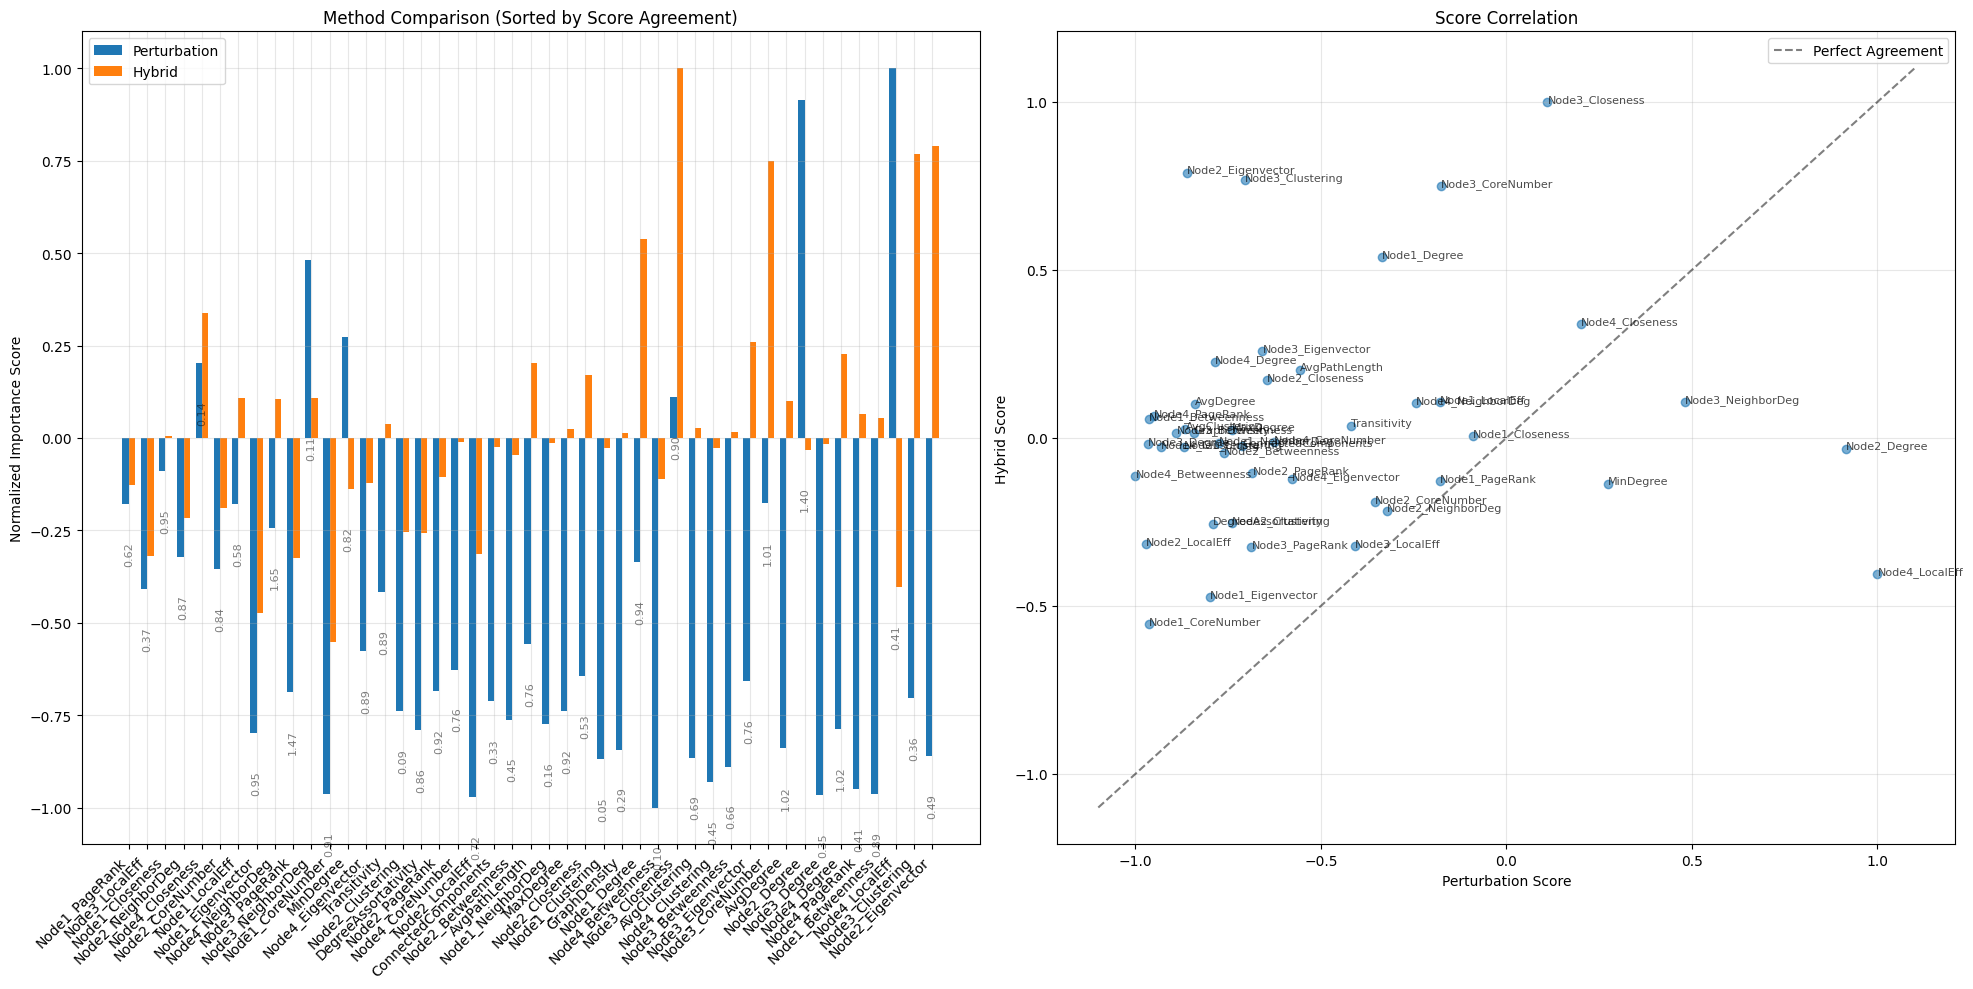

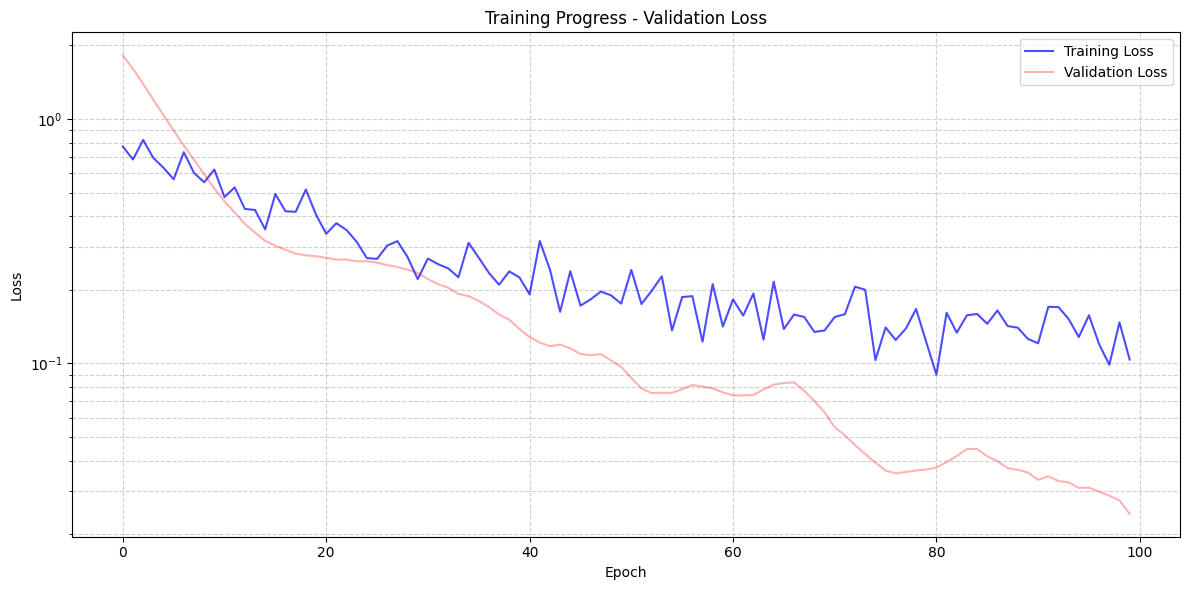

In [243]:
def main():
    # Generate random graph for analysis
    G, selected_nodes = generate_graph(num_nodes=100, edge_prob=0.05)
    
    # Select target feature for analysis
    target_feature = "Node1_Betweenness"
    target_idx = FEATURE_NAMES.index(target_feature)
    
    # Process graph data
    data = process_graph_data(G, selected_nodes, target_idx)
    
    # Initialize and train model
    model = SingleFeatureGNNModel(node_feature_dim=len(FEATURE_NAMES)-1)
    losses, trained_model = train_single_feature_model(
        model, 
        data, 
        target_idx
    )
    
    # Perform feature importance analysis
    compare_analysis_methods(
        G, 
        selected_nodes, 
        target_feature, 
        top_k=10
    )
    
    # Plot training progress
    plot_training_progress(losses)

if __name__ == "__main__":
    main()